<a href="https://colab.research.google.com/github/nicktien007/Nick.Colab/blob/main/Lab/HW4_GRU_Nick_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GRU Final版

1. Label做one hot encoding，**平衡了Label**，從而提昇準確率
2. 準確率、Loss可視化、Test 做熱力圖

Dataset

> Train Data：

https://drive.google.com/file/d/1ZNAILkbWwGuJE914R5cbPv1LzEypWnyW/view?usp=sharing

> Test Data：

https://drive.google.com/file/d/1ZNAILkbWwGuJE914R5cbPv1LzEypWnyW/view?usp=sharing

> word2vec_wiki_zh.model.txt：

https://drive.google.com/file/d/1hCeBokG2oeXc7W45CPzsRH93GgPuMbm9/view?usp=sharing

## 為什麼 **HW4-GRU - Nick1** 的Test只有50% ？？

### Taipei_QA_new Label
筆數：7985筆

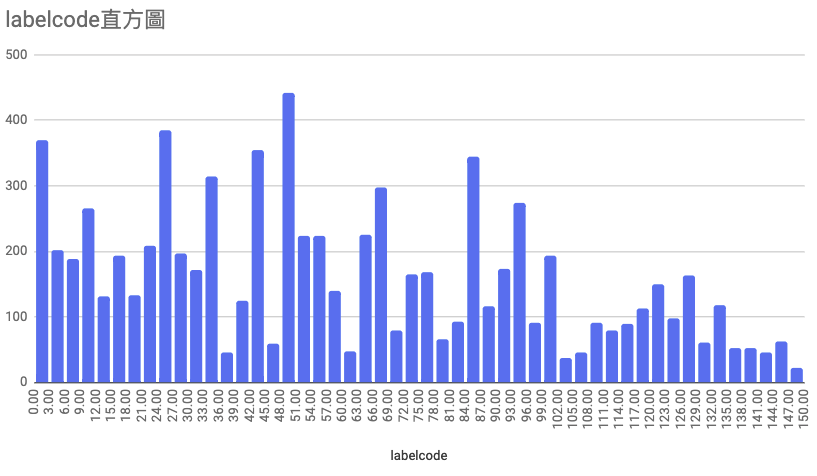

### Taipei_QA_new - 平衡Label
筆數：8194筆

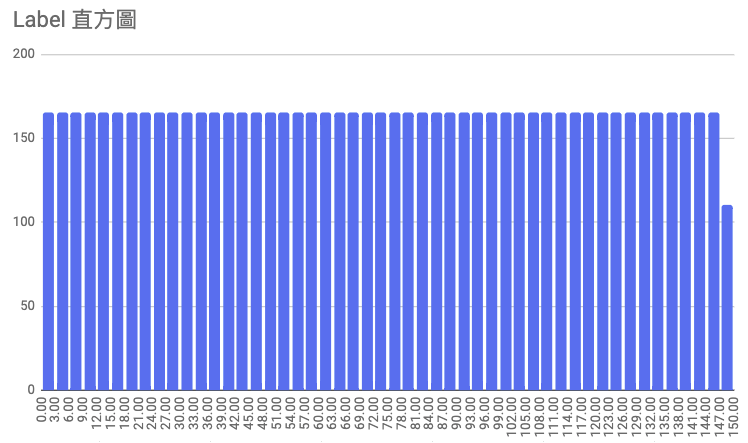

## Initialize

In [9]:
# 取得google drive存取權限
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#定義路徑
SYS_DIR = "/content/drive/MyDrive"

Mounted at /content/drive


In [10]:
!ls drive/MyDrive/

Dataset  HW4  Model  Other  QAbot


In [11]:
import logging

import torch
from torch import nn
from torchtext import data
from torchtext.vocab import Vectors

import numpy as np
import pandas as pd

import time
import math

import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname=SYS_DIR+"/Other/TaipeiSansTCBeta-Bold.ttf")#為了顯示中文，載入一個中文字體

device = torch.device('cuda')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


## Define train & eval

In [12]:
import logging as log


def train_model(model, traindata_loader, testdata_loader,
                criterion, optimizer, num_epoch=25):
    train_loss_all, train_acc_all = [], []
    test_loss_all, test_acc_all = [], []
    learn_rate = []
    since = time.time()

    # 設置等間隔學習率，使得學習率動態變化，每隔step_size個epoch，學習率縮小到原來的1/10
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
    start = time.time()
    for epoch in range(num_epoch):
        learn_rate.append(scheduler.get_last_lr()[0])
        print("-" * 30)
        print("Epoch {}/{}, Lr:{}".format(epoch, num_epoch - 1, learn_rate[-1]))

        # 每個epoch分為訓練階段和驗證階段
        train_loss, train_corrects, train_num = 0, 0, 0
        test_loss, test_corrects, test_num = 0, 0, 0

        model.train()
        for step, batch in enumerate(traindata_loader):
            textdata, target = batch.cutword[0], batch.labelcode.view(-1)
            # 這裡的batch.text[0]代表詞向量，batch.text[1]代表這些詞向量在詞表中的索引index
            out = model(textdata)
            pre_lab = torch.argmax(out, 1)
            loss = criterion(out, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target)
            train_num += len(target)
            if step % 20 == 0:
                log.info(f'[{time_since(start)}] Epoch {epoch} ' + "Train Loss: {:.4f} Train Acc:{:.4f}".format(
                    train_loss / train_num,
                    train_corrects.double().item() / train_num))

        # 計算一個epoch的平均損失值和精度值
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)

        log.info("====Epoch {} Train Loss: {:.4f} Train Acc{:.4f} ====".format(epoch, train_loss_all[-1],
                                                                          train_acc_all[-1]))

        scheduler.step()  # 更新學習率

        # 計算再測試集上的損失和準確率
        model.eval()
        with torch.no_grad():
            for step, batch in enumerate(testdata_loader):
                textdata, target = batch.cutword[0], batch.labelcode.view(-1)
                out = model(textdata)
                pre_lab = torch.argmax(out, 1)
                loss = criterion(out, target)
                test_loss += loss.item() * len(target)
                test_corrects += torch.sum(pre_lab == target)
                test_num += len(target)

        test_loss_all.append(test_loss / test_num)
        test_acc_all.append(test_corrects.double().item() / test_num)

        log.info("====Epoch {} Test Loss: {:.4f} Test Acc{:.4f}====".format(epoch, test_loss_all[-1],
                                                                      test_acc_all[-1]))

    train_process = pd.DataFrame(data={
        "epoch": range(num_epoch),
        "train_loss_all": train_loss_all,
        "train_acc_all": train_acc_all,
        "test_loss_all": test_loss_all,
        "test_acc_all": test_acc_all
    })
    return model, train_process

## Define GRU Model

In [13]:
class GRU2(nn.Module):
    """
    input_size = 400  # input的維度
    hidden_dim = 400  # 隱藏層維度
    num_layers = 1    # GRU迭代次數
    label_num = 149   # 總Label數量
    max_len = max_len # 句子最大長度->60
    batch_size = 1    # batch_size
    """

    def __init__(self, input_size, embedding_dim, hidden_dim, num_layers, output_dim):
        super(GRU2, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_size = input_size
        # self.max_len = max_len

        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.5)  # input_size,  隱藏層維度
        # self.dropout1 = nn.Dropout(p=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)  # 將句向量經過一層liner判斷類別
        # self.dropout = nn.Dropout(p=0.3)
        # self.fc2 = nn.Linear(hidden_dim, output_dim,bias = False)

        # self.fc1 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.Dropout(0.2),
        #     # torch.nn.ReLU(),
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.Dropout(0.3),
        #     nn.Linear(hidden_dim, output_dim)
        # )
        # self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # x : [bacth, time_step, vocab_size]
        embeds = self.embedding(x)
        # embeds : [batch, time_step, embedding_dim]
        r_out, h_n = self.gru(embeds, None)
        # r_out : [batch, time_step, hidden_dim]
        # out = self.fc(r_out[:, -1, :])
        
        # out = self.fc(r_out)
        # out = self.dropout(out)
        out = self.fc(r_out[:, -1, :])
        # out : [batch, time_step, output_dim]
        # return self.dropout(out)
        return out

## Load Train Data

2020-11-27 02:27:59,499 : INFO : Loading vectors from .vector_cache/word2vec_wiki_zh.model.txt.pt


7376 819
['國外', '就學', '原在', '國內', '學校', '就學', '役男', '歲', '含', '以後', '次', '申請', '出境', '國外', '就學', '應', '準備', '證明文件', '機關', '申請', '應填', '申請書', '表', '格式', '處理', '時限']
[64]


<Figure size 1800x1200 with 0 Axes>

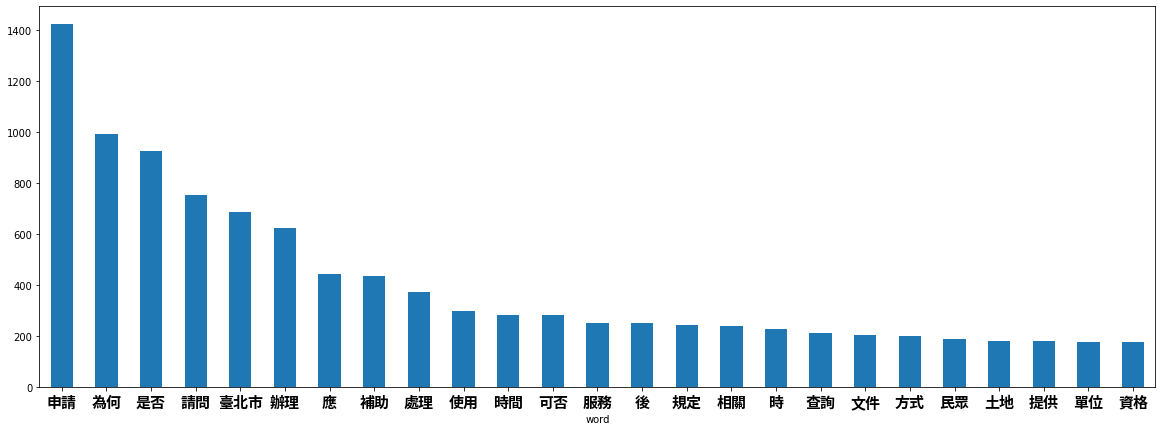

text.shape: torch.Size([32, 400])
pos.shape: torch.Size([32])
label.shape: torch.Size([1, 32])
第一句話前10個字 tensor([ 160,   22,  148,   38,  244, 1425, 1748, 2008,  316,   88],
       device='cuda:0')


<Figure size 1800x1200 with 0 Axes>

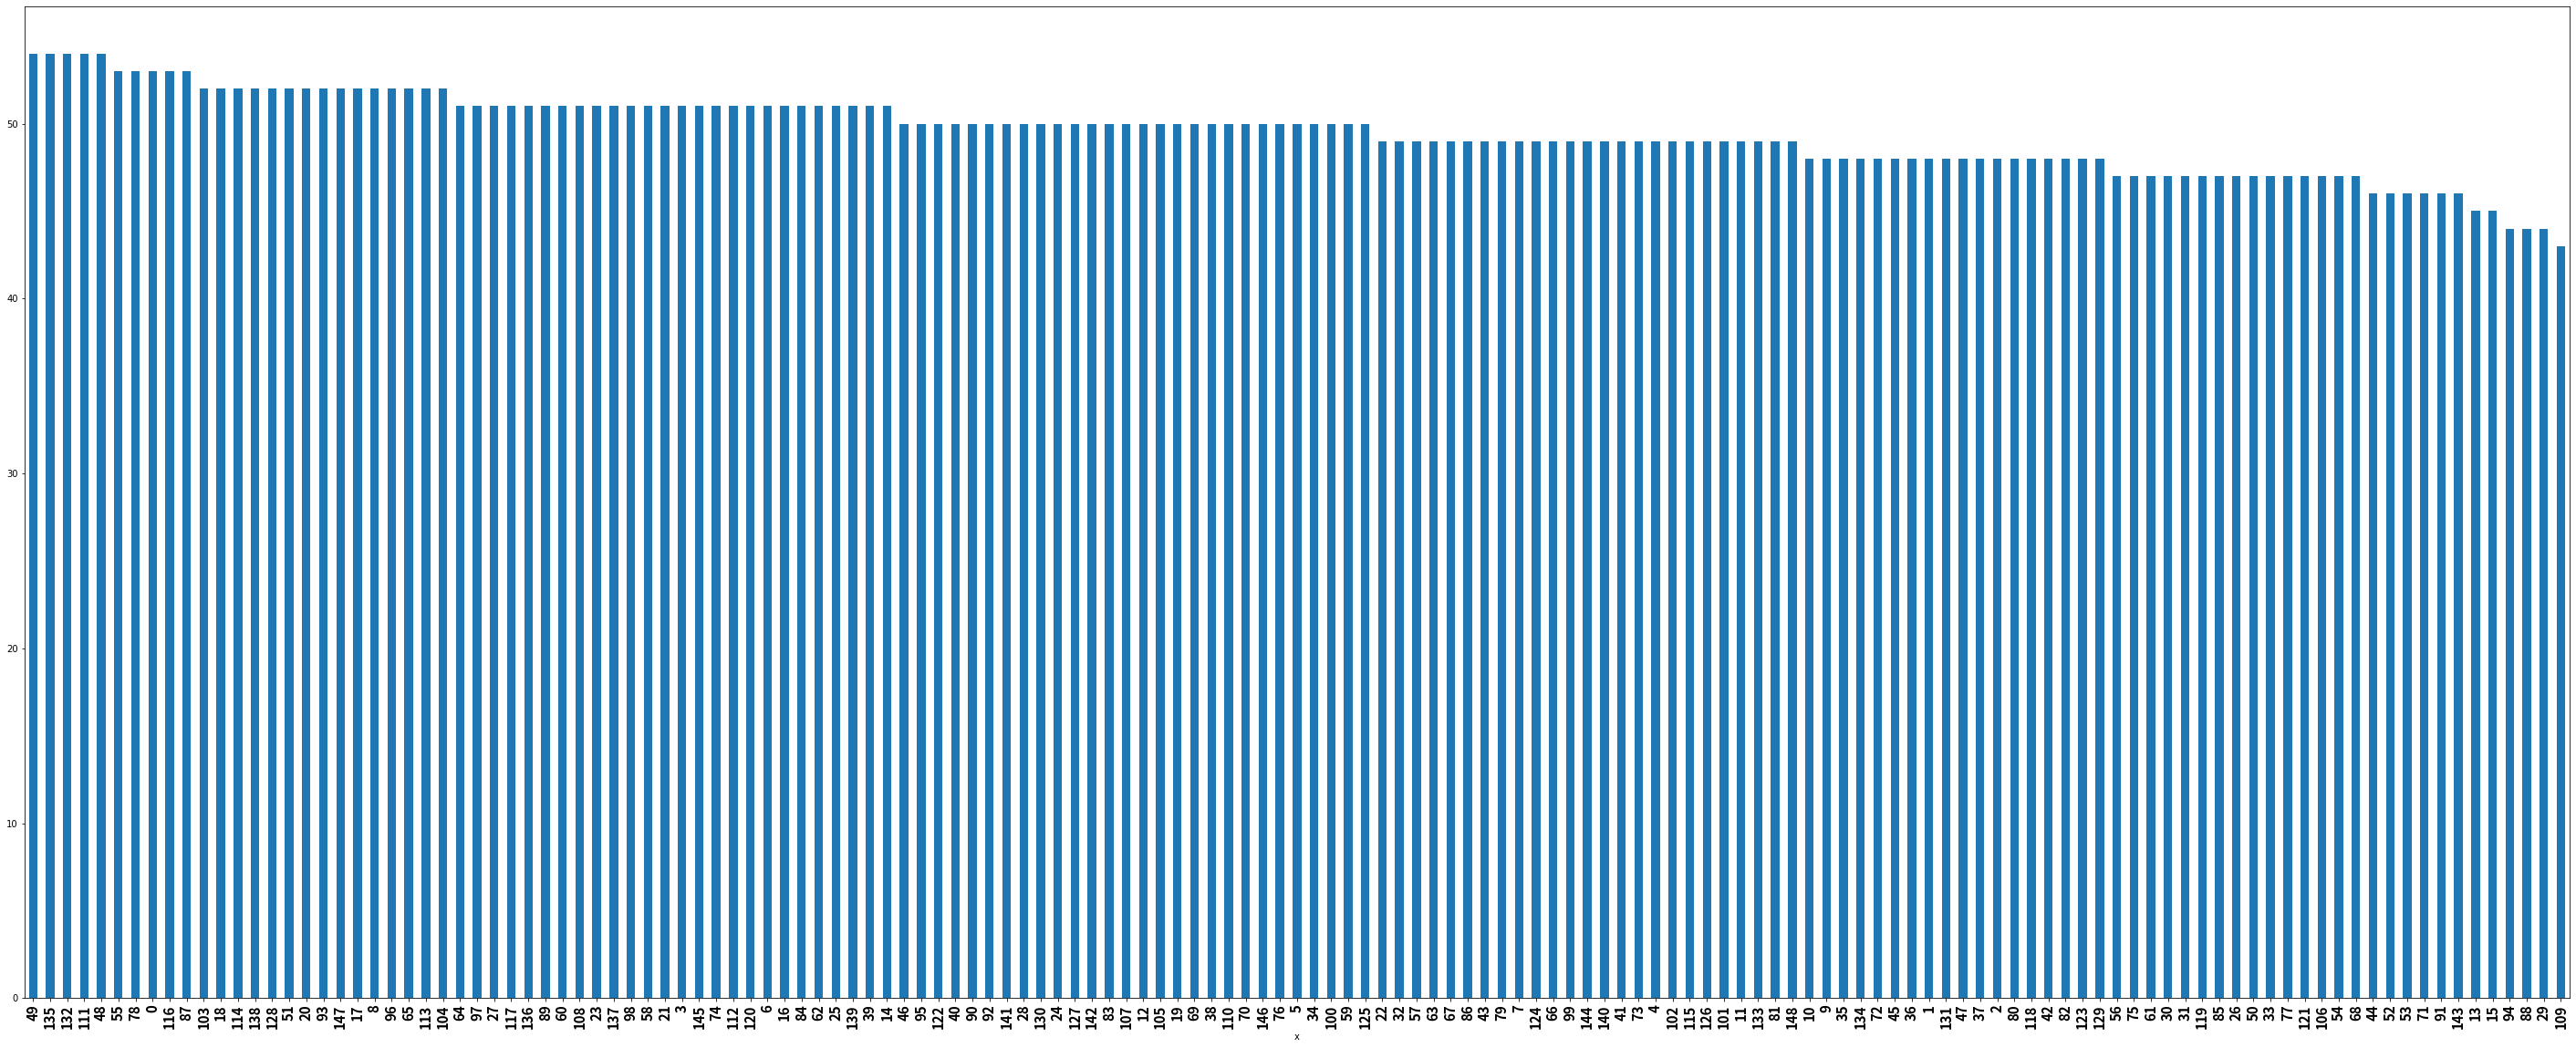

In [14]:
TEXT = data.Field(sequential=True,  # 表明輸入的數據是文本數據
                      tokenize=lambda x: x.split(" "),  # 分詞邏輯
                      include_lengths=True,  # 包含字符長度的信息
                      use_vocab=True,  # 建立詞表
                      batch_first=True,  # batch優先的數據方式
                      fix_length=400  # 每個句子固定長度為400
                      )

LABEL = data.Field(sequential=True,
                    tokenize=lambda x: [int(x)],  # 只有指明sequential=True， tokenize才會被執行
                    use_vocab=False,  # 不創建詞表
                    pad_token=None,  # 不進行填充
                    unk_token=None  # 沒有無法識別的字符
                    )

text_data_field = [
    ("labelcode", LABEL),
    ("cutword", TEXT)
]
# 通過上述方式定義讀取數據的邏輯

traindata, testdata = data.TabularDataset.splits(
    path= SYS_DIR+"/Dataset/HW4", format="csv",
    train="qa_balance_train.csv", fields=text_data_field,
    test="qa_balance_test.csv",
    skip_header=True
)
print(len(traindata), len(testdata))
# print
for item in traindata:
    print(item.cutword)
    print(item.labelcode)
    break

vectors = Vectors(
    name=SYS_DIR+"/Model/Wiki/word2vec_wiki_zh.model.txt"
)

# 建立詞表
TEXT.build_vocab(traindata, max_size=20000, vectors=vectors)
LABEL.build_vocab(traindata)

# 可視化前25個高頻詞
word_fre = TEXT.vocab.freqs.most_common(n=25)
word_fre = pd.DataFrame(data=word_fre, columns=["word", "fre"])

plt.figure(dpi=300)
word_fre.plot(x="word", y="fre", kind="bar", legend=False, figsize=[20, 7])
plt.xticks(rotation=0, fontproperties=fonts, size=15)
# plt.grid(True)
plt.show()

# 定義數據加載器
BATCH_SIZE = 32
train_iter = data.BucketIterator(traindata, batch_size=BATCH_SIZE,device=device)
test_iter = data.BucketIterator(testdata, batch_size=BATCH_SIZE,device=device)

for batch in train_iter:
    text, pos = batch.cutword
    label = batch.labelcode
    print("text.shape:", text.shape)
    print("pos.shape:", pos.shape)
    print("label.shape:", label.shape)
    print("第一句話前10個字", text[0][:10])
    break

# 可視化Label
word_fre = LABEL.vocab.freqs.most_common()
# print(word_fre)
word_fre = pd.DataFrame(data=word_fre, columns=["x", "y"])

plt.figure(dpi=300)
word_fre.plot(x="x", y="y", kind="bar", legend=False, figsize=[50, 20])
plt.xticks(rotation=90, fontproperties=fonts, size=15)
# plt.grid(True)
plt.show()

## Train Model

GRU2(
  (embedding): Embedding(7332, 400)
  (gru): GRU(400, 400, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=400, out_features=149, bias=True)
)
------------------------------
Epoch 0/9, Lr:0.001


2020-11-27 02:28:02,946 : INFO :  0s] Epoch 0 Train Loss: 4.9926 Train Acc:0.0312
2020-11-27 02:28:04,679 : INFO :  2s] Epoch 0 Train Loss: 5.1451 Train Acc:0.0104
2020-11-27 02:28:06,372 : INFO :  3s] Epoch 0 Train Loss: 5.1676 Train Acc:0.0076
2020-11-27 02:28:08,067 : INFO :  5s] Epoch 0 Train Loss: 5.1706 Train Acc:0.0067
2020-11-27 02:28:09,774 : INFO :  7s] Epoch 0 Train Loss: 5.1725 Train Acc:0.0054
2020-11-27 02:28:11,481 : INFO :  8s] Epoch 0 Train Loss: 5.1751 Train Acc:0.0056
2020-11-27 02:28:13,197 : INFO :  10s] Epoch 0 Train Loss: 5.1759 Train Acc:0.0062
2020-11-27 02:28:14,915 : INFO :  12s] Epoch 0 Train Loss: 5.1739 Train Acc:0.0062
2020-11-27 02:28:16,629 : INFO :  13s] Epoch 0 Train Loss: 5.1755 Train Acc:0.0060
2020-11-27 02:28:18,347 : INFO :  15s] Epoch 0 Train Loss: 5.1752 Train Acc:0.0062
2020-11-27 02:28:20,067 : INFO :  17s] Epoch 0 Train Loss: 5.1768 Train Acc:0.0059
2020-11-27 02:28:21,764 : INFO :  19s] Epoch 0 Train Loss: 5.1706 Train Acc:0.0068
2020-11-27

------------------------------
Epoch 1/9, Lr:0.001


2020-11-27 02:28:25,076 : INFO :  22s] Epoch 1 Train Loss: 4.9899 Train Acc:0.0223
2020-11-27 02:28:26,796 : INFO :  24s] Epoch 1 Train Loss: 4.9611 Train Acc:0.0236
2020-11-27 02:28:28,519 : INFO :  25s] Epoch 1 Train Loss: 4.9152 Train Acc:0.0292
2020-11-27 02:28:30,244 : INFO :  27s] Epoch 1 Train Loss: 4.8553 Train Acc:0.0436
2020-11-27 02:28:31,970 : INFO :  29s] Epoch 1 Train Loss: 4.7952 Train Acc:0.0498
2020-11-27 02:28:33,695 : INFO :  31s] Epoch 1 Train Loss: 4.7219 Train Acc:0.0635
2020-11-27 02:28:35,419 : INFO :  32s] Epoch 1 Train Loss: 4.6296 Train Acc:0.0813
2020-11-27 02:28:37,156 : INFO :  34s] Epoch 1 Train Loss: 4.5470 Train Acc:0.0938
2020-11-27 02:28:38,886 : INFO :  36s] Epoch 1 Train Loss: 4.4439 Train Acc:0.1103
2020-11-27 02:28:40,619 : INFO :  37s] Epoch 1 Train Loss: 4.3453 Train Acc:0.1273
2020-11-27 02:28:42,317 : INFO :  39s] Epoch 1 Train Loss: 4.2312 Train Acc:0.1477
2020-11-27 02:28:43,187 : INFO : ====Epoch 1 Train Loss: 4.1801 Train Acc0.1563 ====
20

------------------------------
Epoch 2/9, Lr:0.001


2020-11-27 02:28:45,648 : INFO :  42s] Epoch 2 Train Loss: 2.5271 Train Acc:0.4435
2020-11-27 02:28:47,369 : INFO :  44s] Epoch 2 Train Loss: 2.4394 Train Acc:0.4657
2020-11-27 02:28:49,091 : INFO :  46s] Epoch 2 Train Loss: 2.3719 Train Acc:0.4836
2020-11-27 02:28:50,815 : INFO :  48s] Epoch 2 Train Loss: 2.2763 Train Acc:0.5139
2020-11-27 02:28:52,542 : INFO :  49s] Epoch 2 Train Loss: 2.1685 Train Acc:0.5374
2020-11-27 02:28:54,269 : INFO :  51s] Epoch 2 Train Loss: 2.1202 Train Acc:0.5475
2020-11-27 02:28:55,995 : INFO :  53s] Epoch 2 Train Loss: 2.0660 Train Acc:0.5583
2020-11-27 02:28:57,725 : INFO :  55s] Epoch 2 Train Loss: 2.0065 Train Acc:0.5736
2020-11-27 02:28:59,457 : INFO :  56s] Epoch 2 Train Loss: 1.9558 Train Acc:0.5856
2020-11-27 02:29:01,180 : INFO :  58s] Epoch 2 Train Loss: 1.9023 Train Acc:0.5964
2020-11-27 02:29:02,884 : INFO :  0s] Epoch 2 Train Loss: 1.8517 Train Acc:0.6052
2020-11-27 02:29:03,756 : INFO : ====Epoch 2 Train Loss: 1.8281 Train Acc0.6110 ====
202

------------------------------
Epoch 3/9, Lr:0.001


2020-11-27 02:29:06,259 : INFO :  3s] Epoch 3 Train Loss: 0.8241 Train Acc:0.8452
2020-11-27 02:29:08,013 : INFO :  5s] Epoch 3 Train Loss: 0.7948 Train Acc:0.8377
2020-11-27 02:29:09,760 : INFO :  7s] Epoch 3 Train Loss: 0.7546 Train Acc:0.8438
2020-11-27 02:29:11,517 : INFO :  8s] Epoch 3 Train Loss: 0.7502 Train Acc:0.8418
2020-11-27 02:29:13,278 : INFO :  10s] Epoch 3 Train Loss: 0.7309 Train Acc:0.8465
2020-11-27 02:29:15,039 : INFO :  12s] Epoch 3 Train Loss: 0.7185 Train Acc:0.8456
2020-11-27 02:29:16,791 : INFO :  14s] Epoch 3 Train Loss: 0.7107 Train Acc:0.8455
2020-11-27 02:29:18,549 : INFO :  15s] Epoch 3 Train Loss: 0.7066 Train Acc:0.8455
2020-11-27 02:29:20,311 : INFO :  17s] Epoch 3 Train Loss: 0.7004 Train Acc:0.8467
2020-11-27 02:29:22,072 : INFO :  19s] Epoch 3 Train Loss: 0.6874 Train Acc:0.8486
2020-11-27 02:29:23,833 : INFO :  21s] Epoch 3 Train Loss: 0.6827 Train Acc:0.8494
2020-11-27 02:29:24,688 : INFO : ====Epoch 3 Train Loss: 0.6788 Train Acc0.8496 ====
2020-1

------------------------------
Epoch 4/9, Lr:0.001


2020-11-27 02:29:27,199 : INFO :  24s] Epoch 4 Train Loss: 0.3245 Train Acc:0.9301
2020-11-27 02:29:28,961 : INFO :  26s] Epoch 4 Train Loss: 0.3044 Train Acc:0.9352
2020-11-27 02:29:30,728 : INFO :  28s] Epoch 4 Train Loss: 0.3020 Train Acc:0.9349
2020-11-27 02:29:32,494 : INFO :  29s] Epoch 4 Train Loss: 0.2904 Train Acc:0.9379
2020-11-27 02:29:34,263 : INFO :  31s] Epoch 4 Train Loss: 0.2981 Train Acc:0.9341
2020-11-27 02:29:36,025 : INFO :  33s] Epoch 4 Train Loss: 0.2963 Train Acc:0.9341
2020-11-27 02:29:37,788 : INFO :  35s] Epoch 4 Train Loss: 0.2962 Train Acc:0.9340
2020-11-27 02:29:39,550 : INFO :  36s] Epoch 4 Train Loss: 0.2957 Train Acc:0.9336
2020-11-27 02:29:41,328 : INFO :  38s] Epoch 4 Train Loss: 0.2959 Train Acc:0.9330
2020-11-27 02:29:43,098 : INFO :  40s] Epoch 4 Train Loss: 0.2891 Train Acc:0.9344
2020-11-27 02:29:44,853 : INFO :  42s] Epoch 4 Train Loss: 0.2870 Train Acc:0.9347
2020-11-27 02:29:45,741 : INFO : ====Epoch 4 Train Loss: 0.2826 Train Acc0.9356 ====
20

------------------------------
Epoch 5/9, Lr:0.0001


2020-11-27 02:29:48,277 : INFO :  45s] Epoch 5 Train Loss: 0.1421 Train Acc:0.9807
2020-11-27 02:29:50,058 : INFO :  47s] Epoch 5 Train Loss: 0.1345 Train Acc:0.9794
2020-11-27 02:29:51,841 : INFO :  49s] Epoch 5 Train Loss: 0.1293 Train Acc:0.9790
2020-11-27 02:29:53,619 : INFO :  50s] Epoch 5 Train Loss: 0.1200 Train Acc:0.9815
2020-11-27 02:29:55,406 : INFO :  52s] Epoch 5 Train Loss: 0.1208 Train Acc:0.9817
2020-11-27 02:29:57,187 : INFO :  54s] Epoch 5 Train Loss: 0.1181 Train Acc:0.9822
2020-11-27 02:29:58,972 : INFO :  56s] Epoch 5 Train Loss: 0.1164 Train Acc:0.9816
2020-11-27 02:30:00,747 : INFO :  58s] Epoch 5 Train Loss: 0.1165 Train Acc:0.9819
2020-11-27 02:30:02,538 : INFO :  59s] Epoch 5 Train Loss: 0.1127 Train Acc:0.9824
2020-11-27 02:30:04,322 : INFO :  1s] Epoch 5 Train Loss: 0.1128 Train Acc:0.9820
2020-11-27 02:30:06,072 : INFO :  3s] Epoch 5 Train Loss: 0.1104 Train Acc:0.9826
2020-11-27 02:30:06,964 : INFO : ====Epoch 5 Train Loss: 0.1092 Train Acc0.9829 ====
2020

------------------------------
Epoch 6/9, Lr:0.0001


2020-11-27 02:30:09,535 : INFO :  6s] Epoch 6 Train Loss: 0.0684 Train Acc:0.9940
2020-11-27 02:30:11,334 : INFO :  8s] Epoch 6 Train Loss: 0.0713 Train Acc:0.9931
2020-11-27 02:30:13,137 : INFO :  10s] Epoch 6 Train Loss: 0.0777 Train Acc:0.9913
2020-11-27 02:30:14,947 : INFO :  12s] Epoch 6 Train Loss: 0.0769 Train Acc:0.9915
2020-11-27 02:30:16,757 : INFO :  14s] Epoch 6 Train Loss: 0.0783 Train Acc:0.9913
2020-11-27 02:30:18,571 : INFO :  15s] Epoch 6 Train Loss: 0.0776 Train Acc:0.9910
2020-11-27 02:30:20,384 : INFO :  17s] Epoch 6 Train Loss: 0.0799 Train Acc:0.9902
2020-11-27 02:30:22,209 : INFO :  19s] Epoch 6 Train Loss: 0.0797 Train Acc:0.9901
2020-11-27 02:30:24,032 : INFO :  21s] Epoch 6 Train Loss: 0.0807 Train Acc:0.9893
2020-11-27 02:30:25,856 : INFO :  23s] Epoch 6 Train Loss: 0.0786 Train Acc:0.9899
2020-11-27 02:30:27,680 : INFO :  25s] Epoch 6 Train Loss: 0.0775 Train Acc:0.9900
2020-11-27 02:30:28,568 : INFO : ====Epoch 6 Train Loss: 0.0779 Train Acc0.9900 ====
2020

------------------------------
Epoch 7/9, Lr:0.0001


2020-11-27 02:30:31,199 : INFO :  28s] Epoch 7 Train Loss: 0.0600 Train Acc:0.9926
2020-11-27 02:30:33,054 : INFO :  30s] Epoch 7 Train Loss: 0.0615 Train Acc:0.9924
2020-11-27 02:30:34,900 : INFO :  32s] Epoch 7 Train Loss: 0.0603 Train Acc:0.9944
2020-11-27 02:30:36,761 : INFO :  34s] Epoch 7 Train Loss: 0.0599 Train Acc:0.9946
2020-11-27 02:30:38,628 : INFO :  35s] Epoch 7 Train Loss: 0.0584 Train Acc:0.9950
2020-11-27 02:30:40,506 : INFO :  37s] Epoch 7 Train Loss: 0.0594 Train Acc:0.9943
2020-11-27 02:30:42,377 : INFO :  39s] Epoch 7 Train Loss: 0.0605 Train Acc:0.9940
2020-11-27 02:30:44,257 : INFO :  41s] Epoch 7 Train Loss: 0.0612 Train Acc:0.9938
2020-11-27 02:30:46,130 : INFO :  43s] Epoch 7 Train Loss: 0.0605 Train Acc:0.9938
2020-11-27 02:30:48,018 : INFO :  45s] Epoch 7 Train Loss: 0.0616 Train Acc:0.9930
2020-11-27 02:30:49,876 : INFO :  47s] Epoch 7 Train Loss: 0.0623 Train Acc:0.9929
2020-11-27 02:30:50,819 : INFO : ====Epoch 7 Train Loss: 0.0624 Train Acc0.9930 ====
20

------------------------------
Epoch 8/9, Lr:0.0001


2020-11-27 02:30:53,509 : INFO :  50s] Epoch 8 Train Loss: 0.0482 Train Acc:0.9970
2020-11-27 02:30:55,393 : INFO :  52s] Epoch 8 Train Loss: 0.0534 Train Acc:0.9939
2020-11-27 02:30:57,284 : INFO :  54s] Epoch 8 Train Loss: 0.0539 Train Acc:0.9939
2020-11-27 02:30:59,175 : INFO :  56s] Epoch 8 Train Loss: 0.0523 Train Acc:0.9934
2020-11-27 02:31:01,074 : INFO :  58s] Epoch 8 Train Loss: 0.0516 Train Acc:0.9935
2020-11-27 02:31:02,978 : INFO :  0s] Epoch 8 Train Loss: 0.0526 Train Acc:0.9935
2020-11-27 02:31:04,882 : INFO :  2s] Epoch 8 Train Loss: 0.0529 Train Acc:0.9940
2020-11-27 02:31:06,785 : INFO :  4s] Epoch 8 Train Loss: 0.0534 Train Acc:0.9940
2020-11-27 02:31:08,686 : INFO :  6s] Epoch 8 Train Loss: 0.0534 Train Acc:0.9943
2020-11-27 02:31:10,593 : INFO :  7s] Epoch 8 Train Loss: 0.0523 Train Acc:0.9947
2020-11-27 02:31:12,460 : INFO :  9s] Epoch 8 Train Loss: 0.0521 Train Acc:0.9948
2020-11-27 02:31:13,413 : INFO : ====Epoch 8 Train Loss: 0.0527 Train Acc0.9947 ====
2020-11-

------------------------------
Epoch 9/9, Lr:0.0001


2020-11-27 02:31:16,105 : INFO :  13s] Epoch 9 Train Loss: 0.0567 Train Acc:0.9926
2020-11-27 02:31:17,983 : INFO :  15s] Epoch 9 Train Loss: 0.0503 Train Acc:0.9939
2020-11-27 02:31:19,856 : INFO :  17s] Epoch 9 Train Loss: 0.0487 Train Acc:0.9933
2020-11-27 02:31:21,720 : INFO :  19s] Epoch 9 Train Loss: 0.0453 Train Acc:0.9946
2020-11-27 02:31:23,579 : INFO :  20s] Epoch 9 Train Loss: 0.0450 Train Acc:0.9947
2020-11-27 02:31:25,430 : INFO :  22s] Epoch 9 Train Loss: 0.0454 Train Acc:0.9948
2020-11-27 02:31:27,284 : INFO :  24s] Epoch 9 Train Loss: 0.0444 Train Acc:0.9953
2020-11-27 02:31:29,136 : INFO :  26s] Epoch 9 Train Loss: 0.0443 Train Acc:0.9957
2020-11-27 02:31:30,981 : INFO :  28s] Epoch 9 Train Loss: 0.0461 Train Acc:0.9953
2020-11-27 02:31:32,826 : INFO :  30s] Epoch 9 Train Loss: 0.0463 Train Acc:0.9952
2020-11-27 02:31:34,639 : INFO :  31s] Epoch 9 Train Loss: 0.0462 Train Acc:0.9953
2020-11-27 02:31:35,560 : INFO : ====Epoch 9 Train Loss: 0.0462 Train Acc0.9953 ====
20

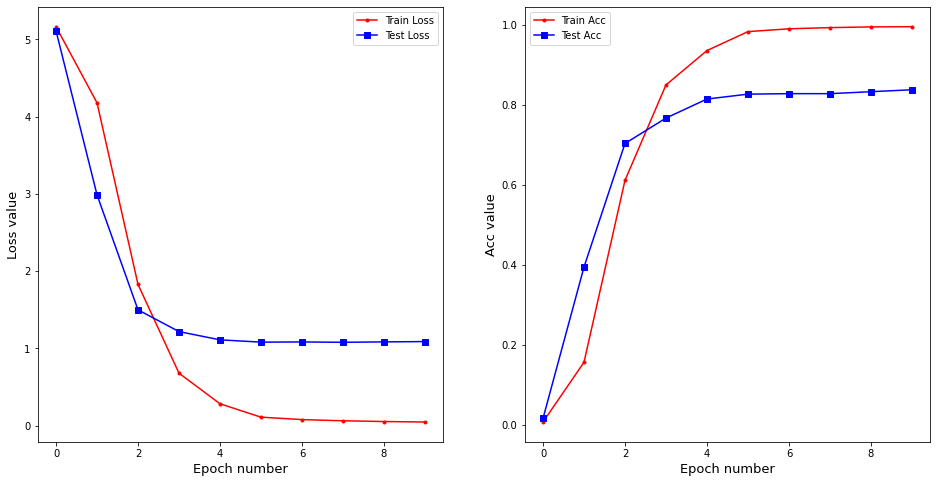

In [15]:
# gru_model
# 定義超參
vocab_size = len(TEXT.vocab)
embedding_dim = 400
hidden_dim = 400
layer_dim = 1
output_dim = 149
epoch = 10

gru_model = GRU2(input_size=vocab_size,
                  embedding_dim=embedding_dim,
                  hidden_dim=hidden_dim,
                  num_layers=layer_dim,
                  output_dim=output_dim)
print(gru_model)

optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
gru_model.to(device)

grumodel, train_process = train_model(gru_model, train_iter, test_iter,
                                      criterion, optimizer, num_epoch=epoch)

torch.save(grumodel, SYS_DIR+"/Model/LAB_HW4_GRU/taipei_qa_GRU.pt")
torch.save(TEXT.vocab, SYS_DIR + "/Model/LAB_HW4_GRU/vocab")

plt.figure(figsize=[16, 8])
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all,
          "r.-", label="Train Loss")
plt.plot(train_process.epoch, train_process.test_loss_all,
          "bs-", label="Test Loss")
plt.xlabel("Epoch number", fontsize=13)
plt.ylabel("Loss value", fontsize=13)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all,
          "r.-", label="Train Acc")
plt.plot(train_process.epoch, train_process.test_acc_all,
          "bs-", label="Test Acc")
plt.xlabel("Epoch number", fontsize=13)
plt.ylabel("Acc value", fontsize=13)
plt.legend()
plt.show()

## Eval Model

在測試集上的精度為:0.8376068376068376


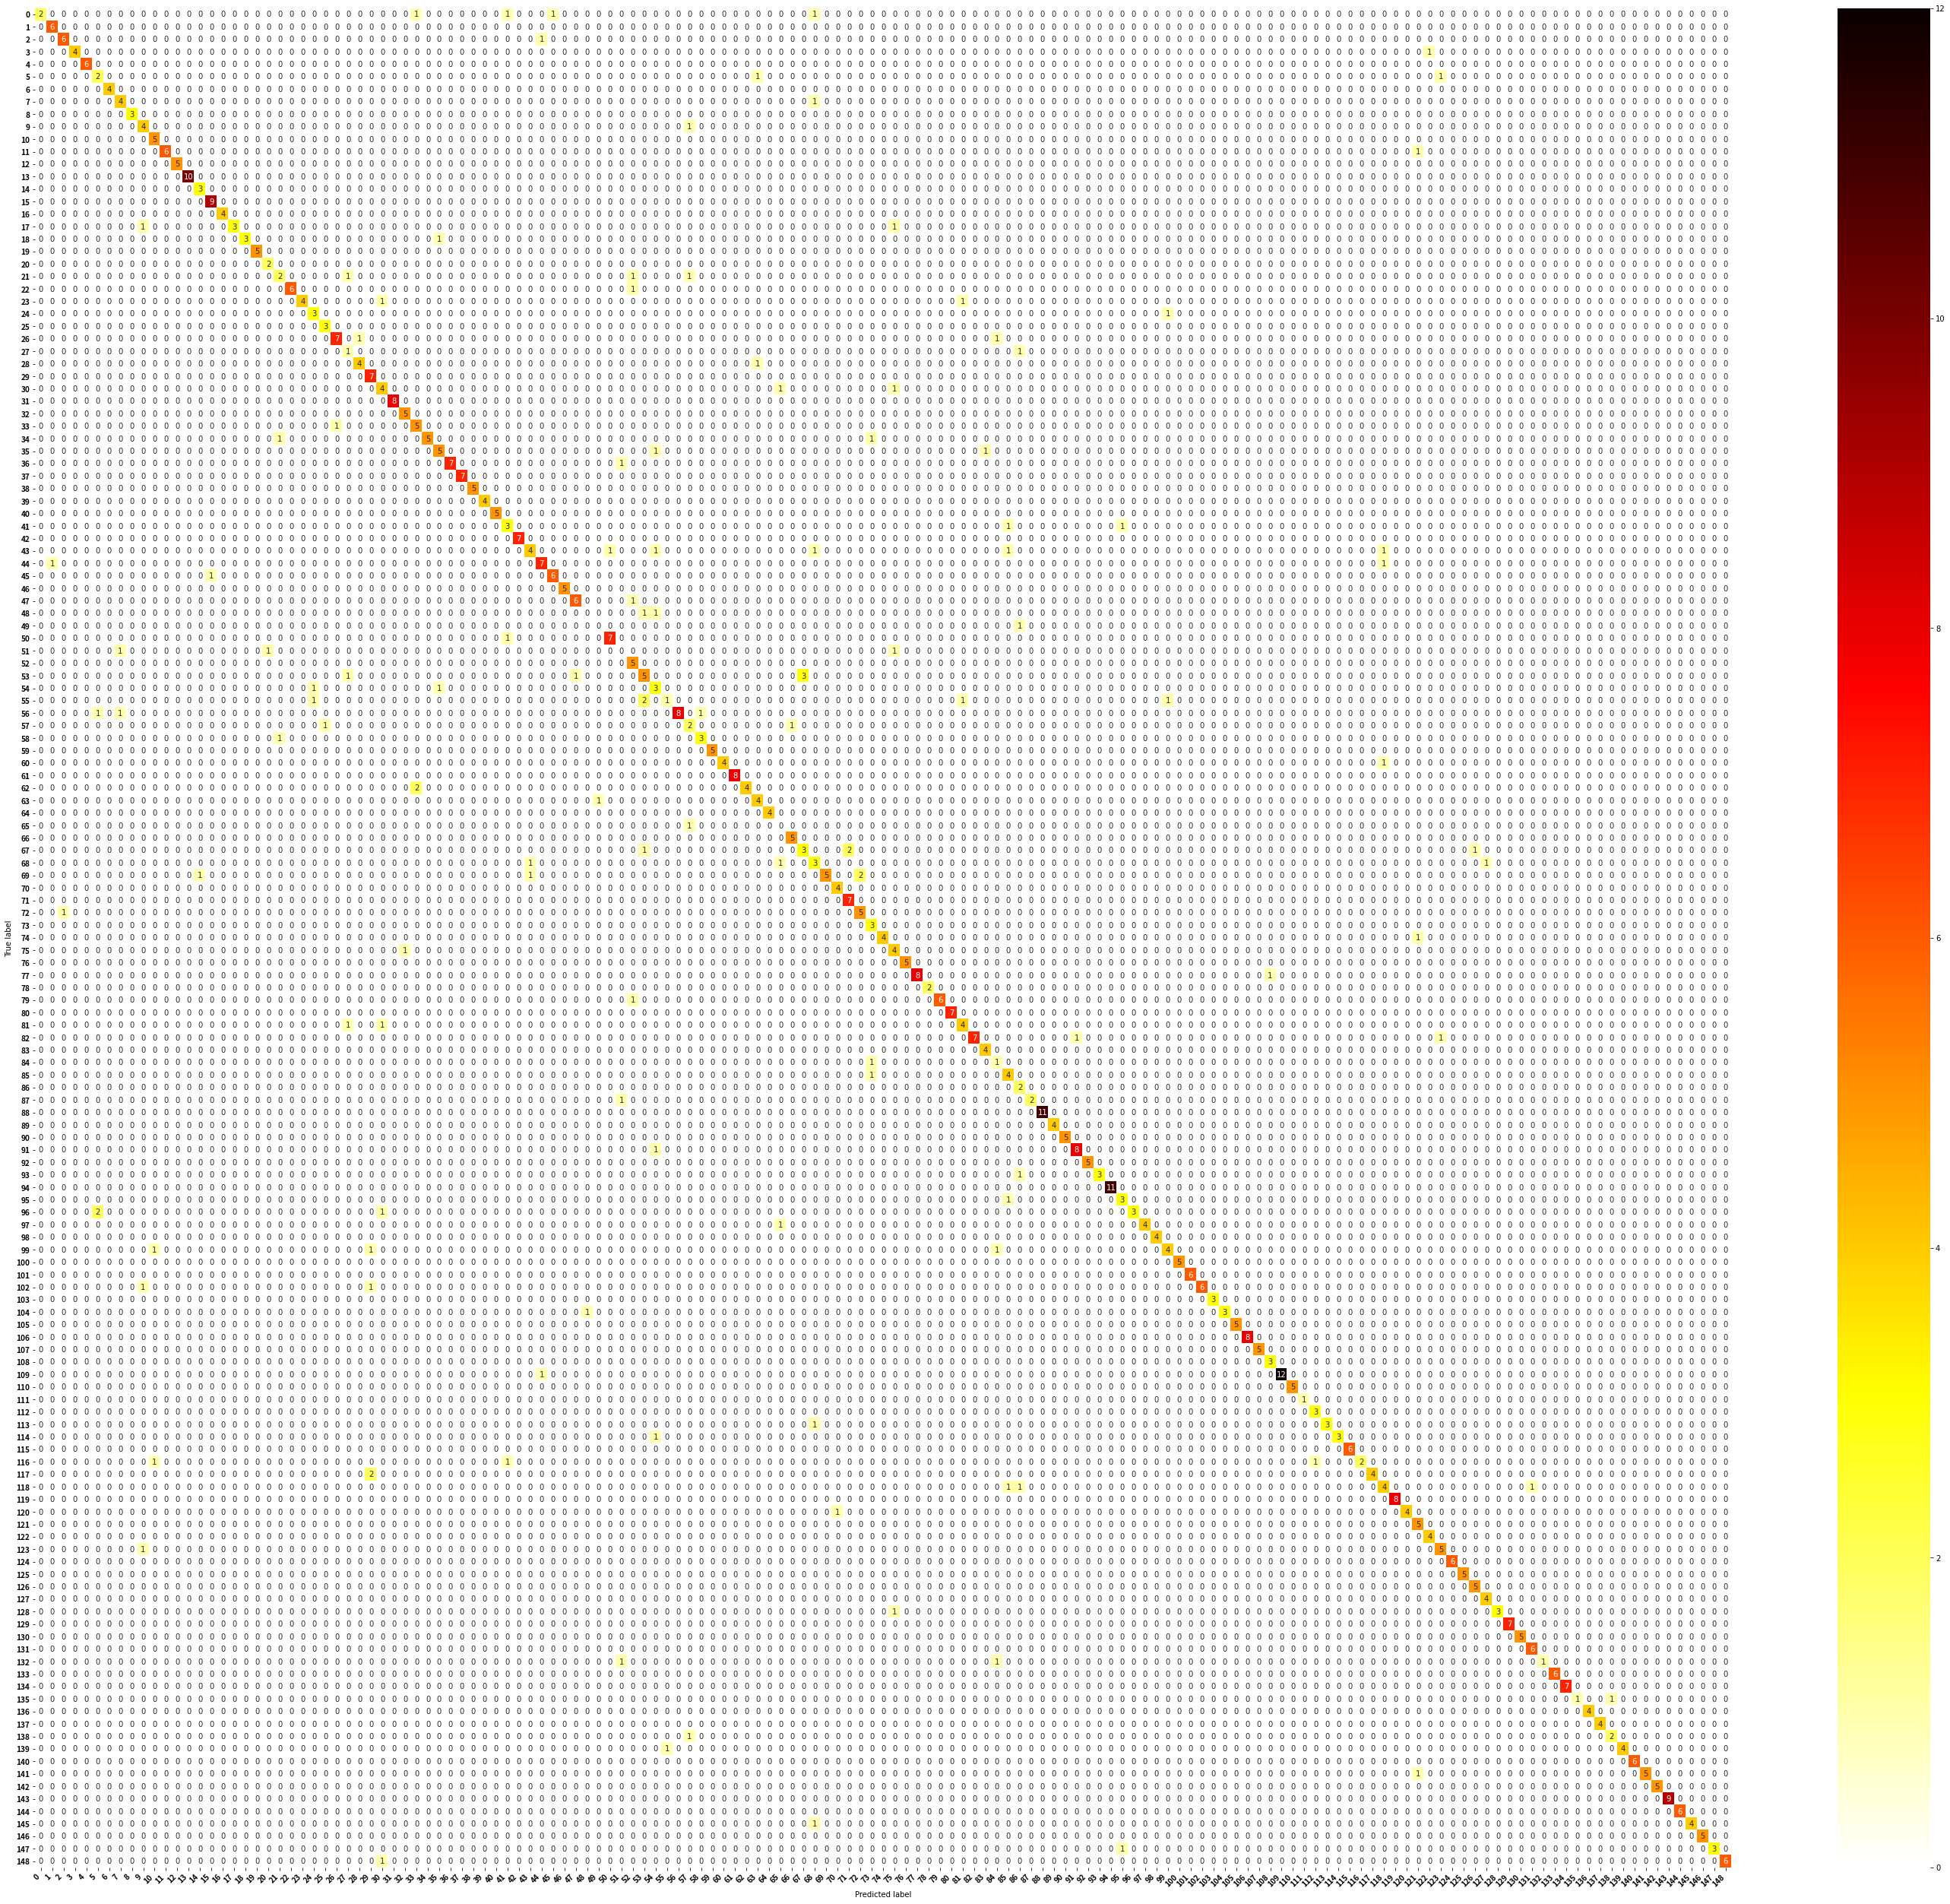

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


def eval_RNN(test_iter):
    rnn_model = torch.load(SYS_DIR+"/Model/LAB_HW4_GRU/taipei_qa_GRU.pt")
    rnn_model.eval()  # 模式設為評估模式，梯度不再更新
    predict_labels = []
    true_labels = []

    for step, batch in enumerate(test_iter):
        textdata, target = batch.cutword[0], batch.labelcode.view(-1)
        out = rnn_model(textdata)
        pre_lab = torch.argmax(out, 1)
        predict_labels += pre_lab.flatten().tolist()
        true_labels += target.flatten().tolist()

    acc = accuracy_score(predict_labels, true_labels)
    print(f"在測試集上的精度為:{acc}")

    class_label = [str(i) for i in range(0,149)]
    # 計算混淆矩陣並可視化
    conf_mat = confusion_matrix(predict_labels, true_labels)
    conf_mat_df = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
        
    # 繪製熱力圖
    plt.subplots(figsize=(50,45))

    heatmap = sns.heatmap(conf_mat_df, annot=True, fmt="d", cmap="hot_r")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                                ha="right", fontproperties=fonts)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                                ha="right", fontproperties=fonts)
        
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()    


eval_RNN(test_iter)

## Refs

- https://bit.ly/37dR7eG
- https://bit.ly/3q3gPLF
- https://bit.ly/2J1VQII
- https://bit.ly/3nZjcx8
- https://bit.ly/33hfMho
- https://bit.ly/379BgOz
- https://bit.ly/3nZCUsE
- https://bit.ly/37b9Do7
- https://bit.ly/2JewVRY
- https://bit.ly/3q5oTM7
- https://bit.ly/33gY2Ty
- https://bit.ly/3q2H2tU
- https://bit.ly/33g3N3x
- https://bit.ly/33iiuTX
- https://bit.ly/39gPO1j
- https://bit.ly/3794vB4
- https://bit.ly/37bYwLO
- https://bit.ly/39lbTfc
- https://bit.ly/33ANa35